# TPM034A Machine Learning for socio-technical systems
## `Lab session 03:  Working with image embeddings`

**Delft University of Technology**<br>
**Q2 2023**<br>
**Instructor:** Sander van Cranenburgh <br>
**TAs:**  Francisco Garrido Valenzuela & Lucas Spierenburg <br>

### `Instructions`

**Lab sessions aim to:**<br>
* Show and reinforce how models and ideas presented in class are used in practice.<br>
* Help you gather hands-on machine learning skills.<br>

**Lab sessions are:**<br>
* Learning environments where you work with Jupyter notebooks and where you can get support from TAs and fellow students.<br>
* Not graded and do not have to be submitted.

### `Use of AI tools`
AI tools, such as ChatGPT and Co-pilot, are great tools to assist with programming. Moreover, in your later careers you will work in a world where such tools are widely available. As such, we **encourage** you to use AI tools **effectively** (both in the lab sessions and assignments). However, be careful not to overestimate the capacity of AI tools! AI tools cannot replace you: you still have to conceptualise the problem, dissect it and structure it, to conduct proper analysis and modelling. We recommend being especially **reticent** with using AI tools for the more conceptual and reflective oriented questions.

### `Workspace set-up`

**Option 1: Local environment**<br>
Uncomment the following cell if you are running this notebook on your local environment. This will install all dependencies on your Python version.

In [ ]:
#!pip install -r requirements.txt

**Option 2: Google Colab**<br>
Uncomment the following cells code lines if you are running this notebook on Colab

In [1]:
!git clone https://github.com/TPM034A/Q2_2023
!pip install -r Q2_2023/requirements_colab.txt
!mv "/content/Q2_2023/Lab_sessions/lab_session_03/data" /content/data
!mv "/content/Q2_2023/Lab_sessions/lab_session_03/assets" /content/assets

Cloning into 'Q2_2023'...
remote: Enumerating objects: 239, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 239 (delta 38), reused 50 (delta 27), pack-reused 159
Receiving objects: 100% (239/239), 94.73 MiB | 19.30 MiB/s, done.
Resolving deltas: 100% (84/84), done.
Updating files: 100% (60/60), done.


### `Application: Predicting perceived visual neighbourhood attractiveness` <br>

In this lab session we will use various ML models, namely Linear regressions (LR), Random forests (RF), Multi-layer perceptrons (MLP), and Ensembles (E), to predict the **perceived visual attractiveness of neighbourhoods**. Understanding the visual attractiveness of neighbourhoods is important for various reasons. For instance, municipalities need to know which neighbourhood need attention because they are visually unattractive. Moreover, visual attractiveness of neighbourhood is important to understand and predict residential location choices, house prices, and tourist destination choices.  

`In this lab session we aim to develop a computationally efficient ML model that is capable of mapping urban images (i.e. a Google Street view image) to visual attractiveness levels`.

**Where do the true labels come from?**<br>

Since we use supervised learning, we need to have data containing the true labels. But where do the true labels for visual attractiveness come from? The true labels come from a computer vision model that is trained on data from a so-called discrete choice experiment. In this experiment, people were placed in the hypothetical situation that they had to move to a different neighbourhood and were given two options. The visual attractiveness is learned from their choices.

See the figure below for an example of one such choice task. More information about the survey and the model can be found in [this paper](https://arxiv.org/abs/2308.08276).

<div>
<center><img src="assets/survey_snapshot.png" width="500"/></center>
</div>

**Why do we need a another model to (re)do the mapping?**<br>

The mapping from image to visual attractiveness indeed already comes from a model. Therefore, one may wonder why do we need another model? Applying the computer vision model is computationally expensive. Moreover, it requires a GPU to process images in large quantities. Therefore, having a good, and **computationally efficient**, proxy model is useful. For instance, to build a map like the one below for Delft requires processing over 400k images.

<div>
<center><img src="assets/visual_attractiveness_Delft.png" width="500"/></center>
</div>

**Data for this lab**<br>

In this lab session you will work with four datasets:

1. `data/image_tabular/image_metadata.csv`: A table csv file with image metadata (e.g., year, month or location) of Rotterdam images.
2. `data/image_tabular/image_embeddings.csv`: A table csv file with image embeddings of images from Rotterdam. (We will explain what image embeddings are later).
3. `data/geo/hexagons.gpkg`: A geospatial dataset of Rotterdam.
4. `data/images`: A folder with image files from Rotterdam (read below for more details).

The first three data files are already in the `data` folder associated with this lab. The `images` folder still needs to be downloaded. The full image data set is fairly large, 14 GB, and contains 101,444 images from Rotterdam. You can download the full dataset if you want to work and explore all the images by your own, but this is not required for completing this lab session. To conduct this lab session, we have created a sub-set of the data set containing 1,000 images which is only 140 MB. This allow you to conduct the visualisations of this lab.

The following cell will download the sub-set of images and place them in the `data` folder automatically. It can takes up to one minute to download the images. If you want to download the full dataset, just modify the the variable `download_full_dataset` to `True`.

In [2]:
## IMPORTANT: You have to be on the TUDelft network (eduroam) or under eduVPN to run this script
download_full_dataset = False

from assets import image_downloader as imd
imd.download_images(download_full_dataset)

Download complete!
Unzipping images...
Unzip complete!
Removing zip file...
Done!


**Learning objectives**. After completing the following exercises you will be able to: <br>
1. Train multiple ML models, including `Linear regressions`, `Random Forests` and `Multi-Layer Perceptrons`
2. Identify the most important features and their impact on the target feature<br>
3. Work with embeddings of images
4. Explore the pros and cons of each model, and how models can complement each other to answer specific research questions <br>

#### `Organisation`
This lab session comprises **`3`** parts:

1. Loading and exploring the data<br>
    1.1. Reading the medatada and geospatial file<br>
    1.2. Exploring the image metadata<br>
    1.3. Exploring the geospatial data<br>
    1.4. Visual inspection of images<br>

2. Image embeddings<br>
    2.1. Embedding model<br>
    2.3. Exploring the embeddings<br>

3. Training multiple models: Regression model, Random forest and MLP for predicting attractiveness<br>
    3.1. Preparing the dataset<br>
    3.2. Linear multiple regression model<br>
    3.4. Random Forest<br>
    3.5. Multilayer perceptrons<br>
    3.6. Comparing and reflecting on the model performances and their outcomes<br>

In [3]:
# Basic libraries
import numpy as np
import pandas as pd
import geopandas as gpd

# ML tools
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer,log_loss

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor

# Visualization libraries
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.tree import plot_tree
from branca.element import Figure

# Other libraries
from pathlib import Path
from shapely.geometry import Point
from PIL import Image
import pickle

#### **1. Loading and exploring the data**
##### 1.1. Reading the medatada and geospatial data

Before creating models, we must understand our datasets. So, first open the image metadata dataset (*data/image_tabular/image_metadata.csv*) which contains general info (metadata) about the images, and the geospatial dataset (*data/geo/hexagons.gpkg*) which contains the spatial zones we will work with.

In [4]:
# Data folder path
data = Path('data')

# Reading image df
img_metadata = pd.read_csv(data/'image_tabular'/'image_metadata.csv')

# Reading hexagons gdf
hexagons = gpd.read_file(data/'geo'/'hexagons.gpkg')

##### 1.2. Exploring the image metadata

The `img_metadata` DataFrame contains the metadata of thousands of Street View Images (SVI) from Rotterdam. With `head()` we can explore its different columns available.

In [5]:
img_metadata.head(5)

img_id              img_path  year  month        lat       lng  \
0       0  image_261669_s_a.png  2019      5  51.992875  4.595223   
1       1  image_261609_s_a.png  2021      1  51.992723  4.595357   
2       2  image_261683_s_a.png  2017      7  51.993201  4.594991   
3       3  image_261590_s_a.png  2016      7  51.991961  4.595907   
4       4  image_261599_s_a.png  2017      7  51.992304  4.595650   

            hex_id  attractiveness  in_folder  
0  8b19694da002fff        0.745663          0  
1  8b19694da003fff        0.729360          0  
2  8b19694da006fff        0.767513          0  
3  8b19694da008fff        0.721686          0  
4  8b19694da00efff        0.572475          0

The dataset contains:

- **img_id**: A unique identifier of an individual image
- **img_path**: Image filename in the image folder
- **year**: Year when the picture was taken
- **month**: Month when the picture was taken
- **lat**: geospatial latitude of the image
- **lng**: geospatial longitude of the image
- **hex_id**: geospatial hexagon id where the image was taken (see more details below)
- **attractiveness**: Numerical value which represent the perceived attractiveness of the image
- **in_folder**: Binary column indicating if the image is in the sub-set of images or not

We look at general statistics of `img_metadata` using `describe()`:

In [6]:
img_metadata.describe()

img_id           year          month            lat  \
count  101444.000000  101444.000000  101444.000000  101444.000000   
mean    50721.500000    2015.483341       6.995032      51.918793   
std     29284.504691       4.358636       2.427367       0.030294   
min         0.000000    2008.000000       1.000000      51.852995   
25%     25360.750000    2014.000000       6.000000      51.891868   
50%     50721.500000    2016.000000       6.000000      51.919943   
75%     76082.250000    2019.000000       9.000000      51.943226   
max    101443.000000    2022.000000      12.000000      51.994166   

                 lng  attractiveness      in_folder  
count  101444.000000   101444.000000  101444.000000  
mean        4.490640       -0.285988       0.009858  
std         0.048692        0.529770       0.098796  
min         4.380001       -2.526708       0.000000  
25%         4.457293       -0.669447       0.000000  
50%         4.489459       -0.319260       0.000000  
75%         4.530447        0.078983       0.000000  
max         4.601524        1.748261       1.000000

In [7]:
img_metadata.shape

(101444, 9)

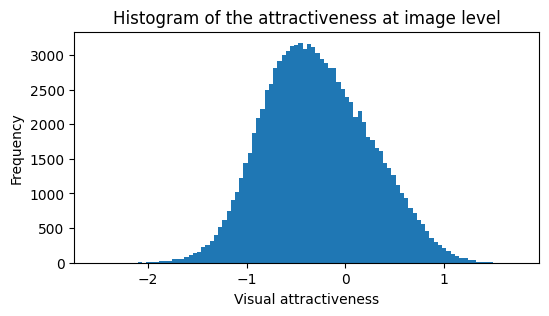

In [8]:
# Histogram of the attractiveness at image level
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(img_metadata['attractiveness'], bins=100)
ax.set_xlabel('Visual attractiveness')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of the attractiveness at image level')
plt.show()

Here we can see:
- that the distribution of the attractiveness values is skewed a bit to the right. This means that there are more images with a more positive attractiveness value than negative.


Now let's briefly see how many images we have per geospatial hexagon. For this we will use the `hex_id` column. This column contains a unique identifier for each hexagon.

### <span style="color:skyblue">Exercise 1: Explore the statistics and geospatial distribution of the images</span>
`A` First, verify how many images are available per hexagon. Visualize by table or plot. <br>
`B` Create histograms of images by year and month. Comment what you see. <br>
`C` Visualize on a map the distribution of year and month (To convert the DataFrame into a GeoDataFrame use the method provided below). Create one map for each year (2008-2022), and for each month (Jan-Dec). Interpret your results.<br>
`D` Do you think the month and year of the images could impact on the (predicition of) perceived visual attractiveness?<br>

In [9]:
def dataframe_to_geodataframe_nl(original_dataframe, latitud_column_name, longitude_column_name):
    '''
    This Function converts a dataframe into a geodataframe using the latitud and longitude columns.
    The output will be ready to use the plot function from geopandas.
    '''

    ## Creating the Point geometry using lat/lng columns
    original_dataframe['geometry'] = original_dataframe.apply(lambda x: Point(x[longitude_column_name], x[latitud_column_name]), axis=1)

    ## Creating the geodataframe (we used crs 4326 because it is the code for the latitud and longitude)
    geodataframe = gpd.GeoDataFrame(original_dataframe, geometry='geometry', crs=4326)

    ## Changing the crs to the same as the hexagons This is 28992, the projection used in the Netherlands.
    geodataframe = geodataframe.to_crs(28992)

    return geodataframe

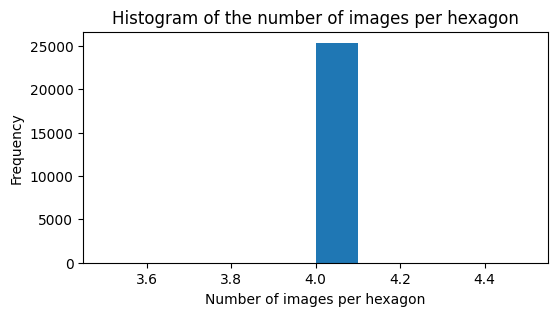

In [10]:
# ADD HERE YOUR ANSWER TO EXERCISE 1

# A. Checking the number of images per hexagon
hex_num_imgs = img_metadata[['hex_id', 'img_id']].groupby('hex_id').count()
hex_num_imgs = hex_num_imgs.rename(columns={'img_id': 'num_imgs'})

fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(hex_num_imgs['num_imgs'])
ax.set_xlabel('Number of images per hexagon')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of the number of images per hexagon')
plt.show()

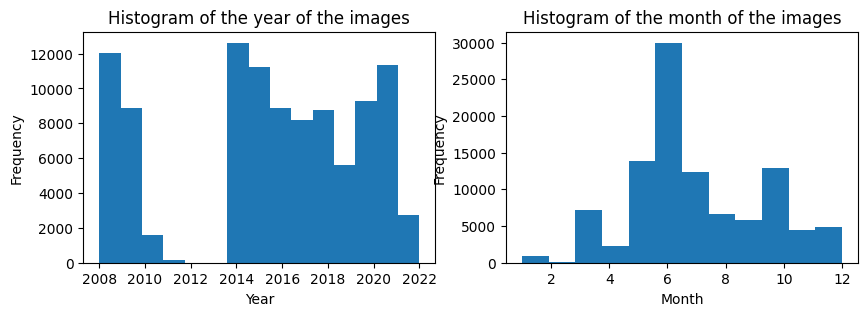

In [11]:
# B. Creating the histogram of images by year and month
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].hist(img_metadata['year'], bins=15)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of the year of the images')
ax[1].hist(img_metadata['month'], bins=12)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of the month of the images')
plt.show()

In [ ]:
# The histogram by years shows a gap between 2011 and 2013. Also 2014 is the year with more images.
# The histogram by month shows that most images are from summer, especially from July.

In [12]:
# C. To visualize the spatial distribution of the data, we can convert the dataframe into a geodataframe using the function provided in the lab session.

img_metadata_gdf = dataframe_to_geodataframe_nl(img_metadata, 'lat', 'lng')

## Now we can plot the data

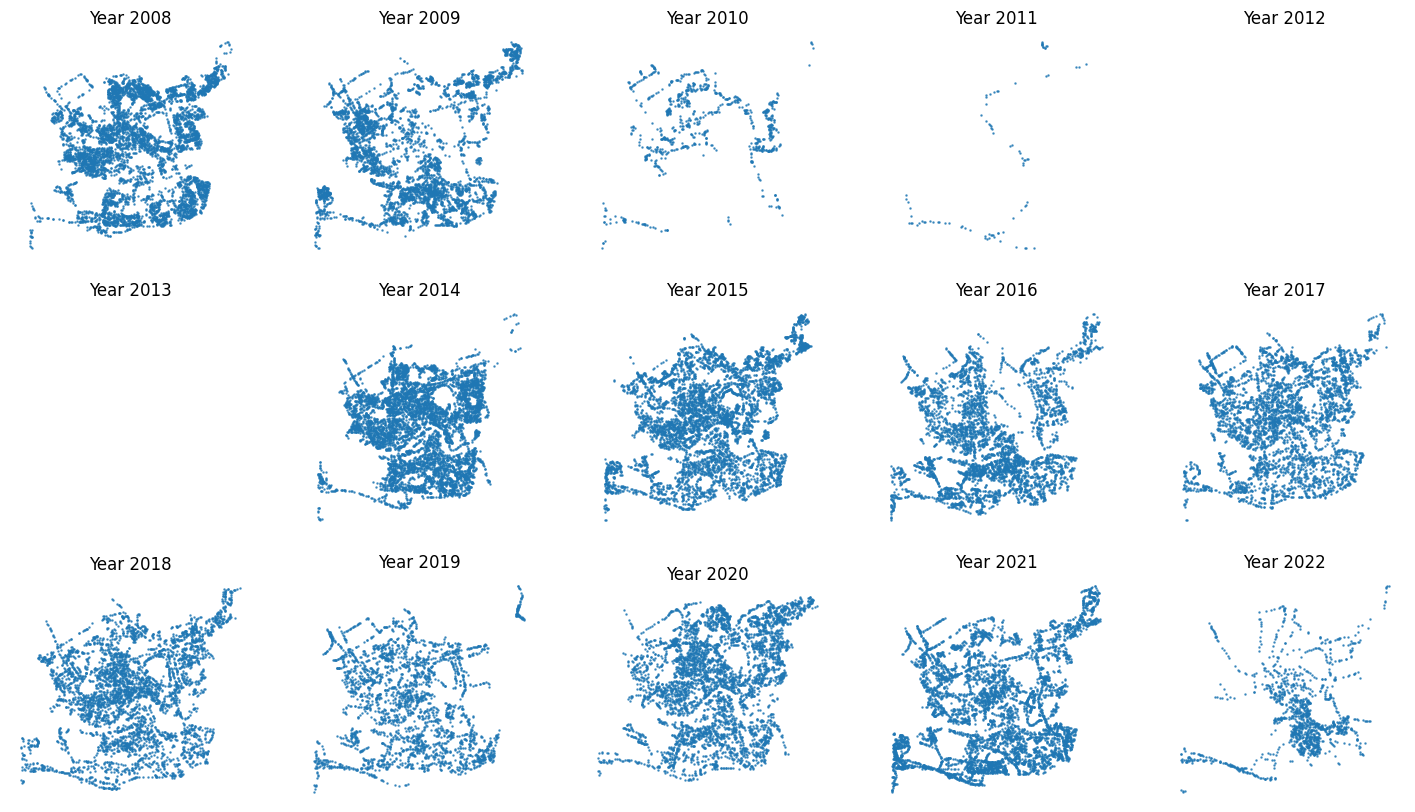

In [13]:
# For years
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18, 10))
for ax, year in zip(axes.flatten(), range(2008, 2023)):
    if len(img_metadata[img_metadata.year == year]) > 0:
        img_metadata_gdf[img_metadata.year == year].plot(ax=ax, markersize=0.5, alpha=0.5)
    ax.set_title('Year {}'.format(year))
    ax.set_axis_off()
plt.show()

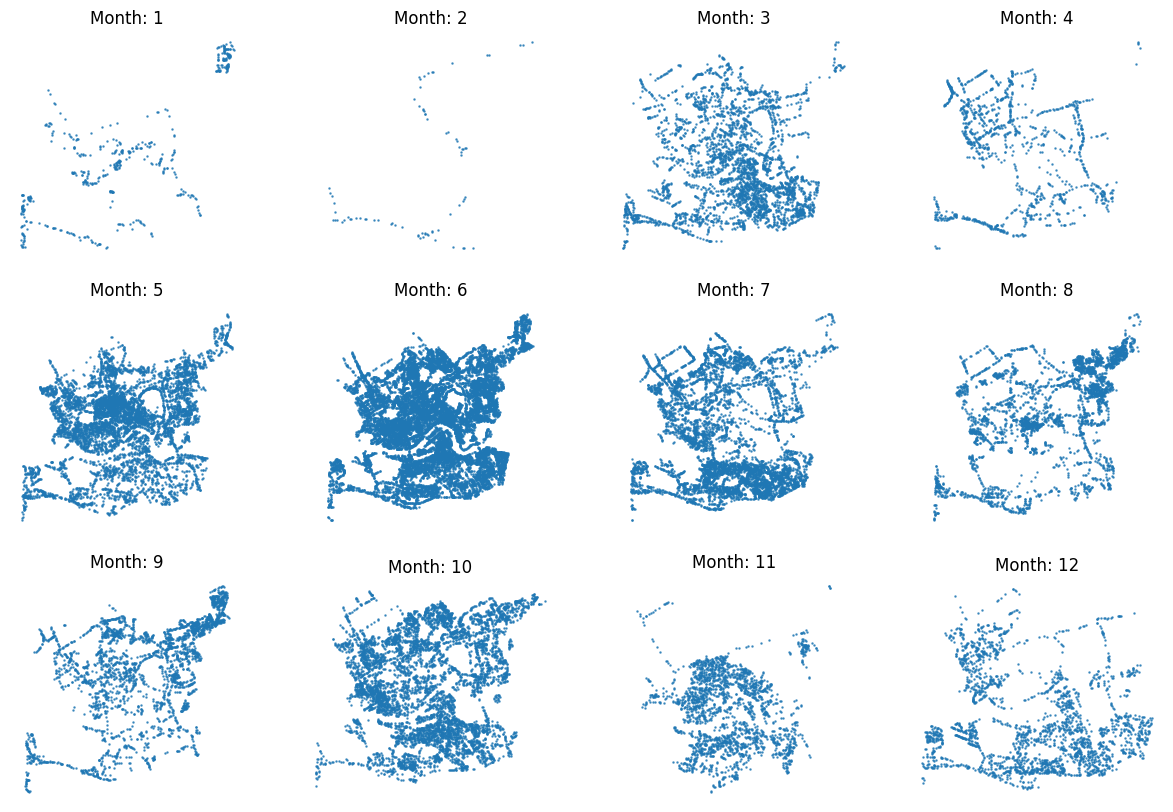

In [14]:
# The same for each month
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for ax, month in zip(axes.flatten(), range(1, 13)):
    if len([img_metadata.month == month]) > 0:
        img_metadata_gdf[img_metadata.month == month].plot(ax=ax, markersize=0.5, alpha=0.5)
    ax.set_title('Month: {}'.format(month))
    ax.set_axis_off()
plt.show()

In [15]:
# The maps show that from 2014 images have been taken broadly across the city. Most of the images are from summer time where also there is a broader coverage.

# D. Summer pictures maybe are more attractive than winter pictures beacuse there are more green vegetation.

##### 1.3. Exploring the geospatial data

The second dataset *hexagons* corresponds to a geospatial dataset of hexagons.

In [16]:
hexagons.head(5)

hex_id                                           geometry
0  8b19694da002fff  POLYGON ((4.59455 51.99293, 4.59460 51.99270, ...
1  8b19694da003fff  POLYGON ((4.59496 51.99263, 4.59500 51.99240, ...
2  8b19694da006fff  POLYGON ((4.59482 51.99331, 4.59486 51.99309, ...
3  8b19694da008fff  POLYGON ((4.59577 51.99204, 4.59582 51.99181, ...
4  8b19694da00efff  POLYGON ((4.59537 51.99234, 4.59541 51.99211, ...

The dataset contains only two columns. The first one, **hex_id**, it is just a unique identifier for each hexagon. The second one, **geometry**, corresponds to the coordinates of the shape and location of each hexagon. The following code, allow us to visualize each hexagon on the map using the method `explore()` from GeoPandas

In [17]:
fig = Figure(width=400, height=300)
fig.add_child(hexagons.explore(marker_kwds={'radius': 10}, zoom_start=15))
display(fig)

Output hidden; open in https://colab.research.google.com to view.

As you can see in the map, each hexagon covers a piece of land in the city. During this lab, we will treat a hexagon as a neighbourhood. As we described before, each image from the *images* DataFrame is associated with an hexagon id (*hex_id column*), meaning that each image belongs to a neighbourhood. Now it is time to explore the (geo)relation of these two datasets.

### <span style="color:skyblue">Exercise 2: Do you recongnize some geospatial patterns of the attractiveness?</span>
`A` Compute the average attractiveness *per hexagon*<br>
`B` Merge both DataFrames on the column *hex_id*<br>
`C` Visualise the average attractiveness of each neighbourhood, using the `explore()` method of geopandas<br>
`D` Do you see spatial patterns in the map? Hint: check for areas with parks, highways, and other places that you know. Does the map make intuitive sense to you?<br>

In [18]:
# ADD HERE YOUR ANSWER TO EXERCISE 1

# A. Getting the average attractiveness of each hexagon
hex_avg_attrac = img_metadata[['hex_id', 'attractiveness']].groupby('hex_id').mean()

# B. Adding the average attractiveness levels to the hexagons of the  geodataframe
hex_avg_attrac = pd.merge(hexagons, hex_avg_attrac, on='hex_id', how='left')

In [19]:
# Now we have an average attractiveness for each hexagon.
hex_avg_attrac.head(5)

hex_id                                           geometry  \
0  8b19694da002fff  POLYGON ((4.59455 51.99293, 4.59460 51.99270, ...   
1  8b19694da003fff  POLYGON ((4.59496 51.99263, 4.59500 51.99240, ...   
2  8b19694da006fff  POLYGON ((4.59482 51.99331, 4.59486 51.99309, ...   
3  8b19694da008fff  POLYGON ((4.59577 51.99204, 4.59582 51.99181, ...   
4  8b19694da00efff  POLYGON ((4.59537 51.99234, 4.59541 51.99211, ...   

   attractiveness  
0        0.270133  
1        0.351845  
2        0.791481  
3        0.766068  
4        0.681892

In [20]:
# C. Plotting the average attractiveness of hexagons
fig = Figure(width=600, height=400)

fig.add_child(hex_avg_attrac.explore(column = 'attractiveness', cmap = 'RdYlGn', scheme = 'quantiles'))
display(fig)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# D. There is a clear pattern of attractiveness in the city. The most relatively unattractive areas are the city center compared to the periphery.
# The most attractive areas are the city's periphery, especially the south and the northeast, where parks and green areas are located.

##### 1.4. Visual inspection of images and attractiveness

The full image dataset contains 101,444 images. To easily visualise street images in your computer we have created a representative sample with 1,000 images located on the image folder inside data folder. Let's see an example how to visualize an image in an IPython notebook.

In [19]:
image_path = lambda file: data/'images'/file
visual_images = img_metadata.loc[img_metadata['in_folder'] == 1].copy()

Run the following cell several times to see different images.

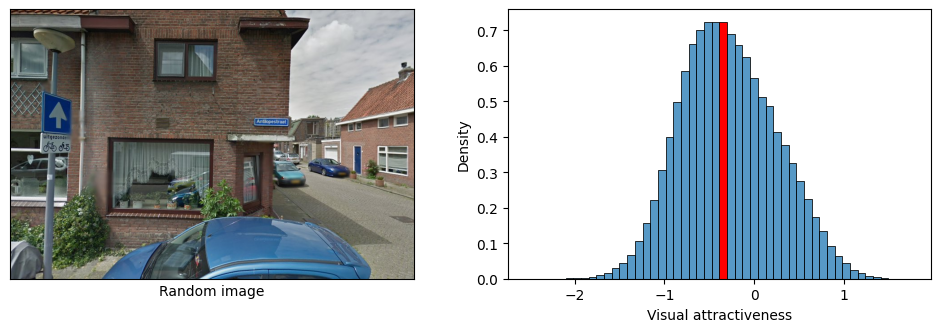

In [21]:
# Create a figure
fig, ax = plt.subplots(1,2,figsize=(12,3.5))

# Draw a random image
rnd_img = visual_images.sample(1)[['img_path','attractiveness']]

# Visualising the random image
img = Image.open(image_path(rnd_img.iloc[0]['img_path'])).convert('RGB')
ax[0].imshow(img)

# Remove the axis
# ax[0].axis('off')
ax[0].set_xlabel('Random image')
ax[0].set_xticks([])
ax[0].set_yticks([])

# Add the histogram of the attractiveness of all 101k images
sns.histplot(img_metadata['attractiveness'],bins=50, stat='density', ax=ax[1])
ax[1].set_xlabel('Visual attractiveness')

# Show where its attractiveness is located in the distribution
img_attractiveness = rnd_img.iloc[0]['attractiveness']
bin_edges = ax[1].patches
for patch in bin_edges:
    if patch.get_x() <= img_attractiveness <= patch.get_x() + patch.get_width():
        patch.set_facecolor('red')
plt.show()

**Reflection**<br>
Across the board the location in the distribution makes sense. But, some unattractive streetviews are predicted as being fairly attractive (and vice versa).

Now we go one step further, and visualise images based on its levels of attractiveness. Modify the number of percentiles (`n_percentiles`) and the number of images per percentile (`images_per_row`) to explore different groups of images.

Images from lower percentile are less attractive than images from higher percentiles based on its attractiveness value. Take a look to this images and see if makes sense to you.

In [22]:
# Set the number of percentiles and images per row
n_percentiles = 6
images_per_row = 5

# Create a new column with the quantile
visual_images['quantile'], quantile_boundaries = pd.qcut(visual_images['attractiveness'], n_percentiles, labels=False, retbins=True)

# Create a figure with a grid
fig = plt.figure(figsize=(20., 100.))
grid = ImageGrid(fig, 111, nrows_ncols=(n_percentiles,images_per_row+1),axes_pad=0.05)

#
for i in range(n_percentiles):
    # Draw 'images_per_row' random images from the quantile i
    auxs = visual_images[visual_images['quantile']==i].sample(images_per_row)[['img_path', 'attractiveness']].reset_index(drop=True)

    # Plot the images in the grid
    for j, row in auxs.iterrows():
        img = Image.open(image_path(row['img_path'])).convert('RGB')
        grid[(i*(images_per_row+1))+j+1].imshow(img)
        grid[(i*(images_per_row+1))+j+1].axis('off')

    # Add the quantile label and the quantile boundaries
    grid[i*(images_per_row+1)].text(-300, 300, f'Quantile {i+1}\n ({quantile_boundaries[i]:0.2f}, {quantile_boundaries[i+1]:0.2f})', fontsize=15, ha='center', va='center')

    # Do not show axis
    grid[i*(images_per_row+1)].axis('off')

# Show the figure
plt.show()

Output hidden; open in https://colab.research.google.com to view.

We can inspect the tails of the distribution. That is, we can inspect the **most attractive** images and the **least attractive** images.

Here we see the 10 least attractive images.

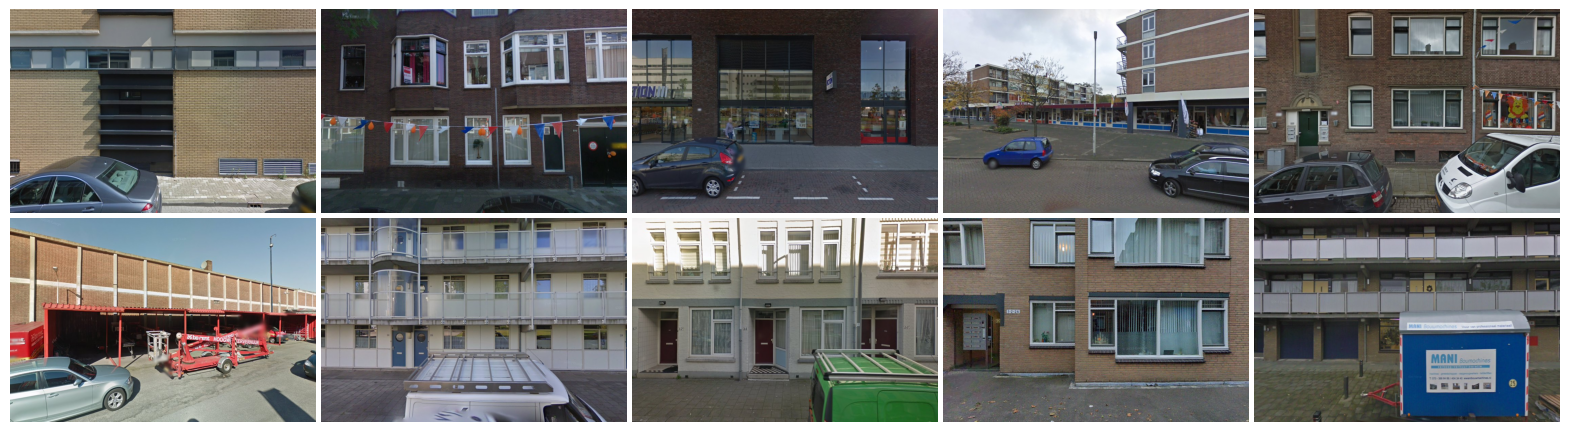

In [23]:
# Set the number of images per row
images_per_row = 5

# Sort the images by attractiveness and get the first and last images
mins = visual_images.sort_values(by='attractiveness', ascending=True).head(images_per_row*2).reset_index(drop=True)

# Create a figure with a grid
fig = plt.figure(figsize=(20., 100.))
grid = ImageGrid(fig, 111, nrows_ncols=(2,images_per_row),axes_pad=0.05)

# Plot the images in the grid
for i, row in mins.iterrows():
    img = Image.open(image_path(row['img_path'])).convert('RGB')
    grid[i].imshow(img)

    # Do not show axis
    grid[i].axis('off')

# Show the figure
plt.show()

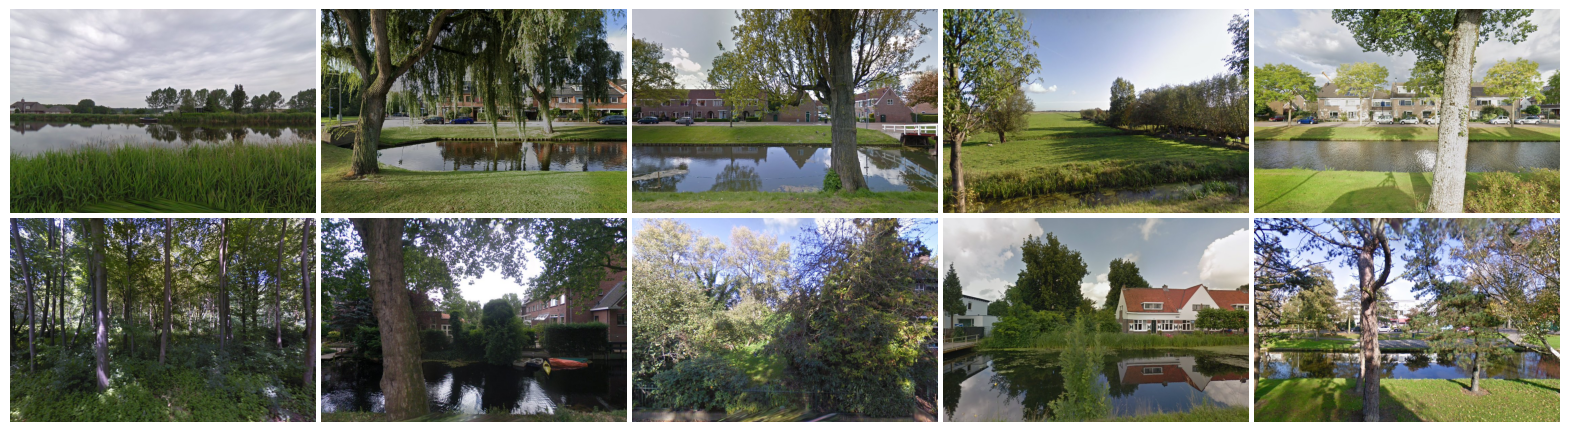

In [24]:
# Set the number of images per row
images_per_row = 5

# Sort the images by attractiveness and get the first and last images
maxs = visual_images.sort_values(by='attractiveness', ascending=True).tail(images_per_row*2).reset_index(drop=True)

# Create a figure with a grid
fig = plt.figure(figsize=(20., 100.))
grid = ImageGrid(fig, 111, nrows_ncols=(2,images_per_row),axes_pad=0.05)

# Plot the images in the grid
for i, row in maxs.iterrows():
    img = Image.open(image_path(row['img_path'])).convert('RGB')
    grid[i].imshow(img)

    # Do not show axis
    grid[i].axis('off')

# Show the figure
plt.show()

**Question**<br>
Do you agree with the model's assessment of the least and most visually attractive images? Why?

#### **2. Image embeddings**
##### 2.1. Embedding model

Until now we have only visualised the images. But we would like to work with them. For that we need to transform the images into lower dimensional mathematical representations that allows for algorithmic processing. This mathematical representation is called an embedding. For instance, an image has 720 x 320 x 3 (heigh x width x color channels) pixels, while an embedding of that image typically contain only between 20 and 2,000 floating points. The figure shows conceptually shows how a classic Convolution Neural Network (CNN) produces an image embedding - which is also called **feature map**.



The image embedding that we will work with is generated by the computer model that produces the visual attractiveness scores. More generally, embedding producesed by trained models are widely used for other related tasks, such as clustering, similarity search, etc.

<div>
<img src="assets/image_embbeding.png" width="500"/>
</div>

To obtain the embeddings, we need to apply the trained computer vision model to the images we are working with in this lab session. However, because this is technically beyong the scope of this course, we have already proccesed the images in advance and saved the embeddings in a csv file for you. In the following cell we load the embeddings.

In [21]:
# Load the embeddings
embeddings = pd.read_csv(data/'image_tabular'/'image_embeddings.csv')

##### 2.1. Exploring the embeddings

In [22]:
embeddings.head()

img_id   Fhat000   Fhat001   Fhat002   Fhat003   Fhat004   Fhat005  \
0       0 -0.721522  0.232802  0.139053  0.332571 -0.643862  0.063346   
1       1 -0.623503  0.638402  0.658155  0.192114 -0.627638  0.011822   
2       2 -0.100401  0.421808  1.200465 -0.040461 -0.798148 -0.101276   
3       3  0.161000  0.808097  0.024000  0.184818 -0.909536  0.111023   
4       4  0.643868  0.463769  0.912675 -0.136469 -0.955919 -0.282816   

    Fhat006   Fhat007   Fhat008  ...   Fhat015   Fhat016   Fhat017   Fhat018  \
0 -0.143065  0.197804  0.627572  ...  0.093596 -0.024934 -0.183208 -0.329915   
1 -0.144213  0.119007  0.454119  ...  0.278526  0.025043 -0.273027 -0.256410   
2 -0.656213  0.018648 -0.331052  ... -0.053597 -0.061117  0.003480 -0.470245   
3 -0.225173  0.245244 -0.088505  ...  0.083257 -0.193682 -0.133317 -0.243234   
4 -0.506169 -0.169948 -0.242296  ...  0.126639 -0.009587  0.236805 -0.441034   

    Fhat019   Fhat020   Fhat021   Fhat022   Fhat023   Fhat024  
0  0.334317 -0.034518 -0.005868 -0.170634 -0.033538 -0.085577  
1  0.200388 -0.166567  0.180788 -0.246929  0.179483  0.129283  
2 -0.163239  0.103589 -0.206567 -0.512829 -0.079979 -0.046585  
3  0.292501 -0.263785 -0.194097 -0.337674 -0.119035  0.036482  
4 -0.283703 -0.013882  0.274577 -0.402516 -0.147622  0.223398  

[5 rows x 26 columns]

As we can see, the embeddings have 25 elements. It means, each image is represented by 25 latent features. We don't know what these features semantically mean. But we can use them to work with the images.

In [23]:
embeddings.describe()

img_id       Fhat000       Fhat001       Fhat002       Fhat003  \
count  101444.000000  1.014440e+05  1.014440e+05  1.014440e+05  1.014440e+05   
mean    50721.500000 -2.080833e-15 -9.357725e-16 -2.736434e-15 -4.974724e-15   
std     29284.504691  6.683317e-01  6.462813e-01  5.985799e-01  5.460809e-01   
min         0.000000 -2.205926e+00 -2.203099e+00 -2.196433e+00 -2.103170e+00   
25%     25360.750000 -4.672549e-01 -4.398960e-01 -4.065295e-01 -3.735691e-01   
50%     50721.500000 -3.127995e-02 -3.082165e-02 -1.821871e-03  2.867939e-03   
75%     76082.250000  4.443619e-01  4.109933e-01  4.118485e-01  3.631078e-01   
max    101443.000000  2.526723e+00  3.405483e+00  2.218247e+00  2.476780e+00   

            Fhat004       Fhat005       Fhat006       Fhat007       Fhat008  \
count  1.014440e+05  1.014440e+05  1.014440e+05  1.014440e+05  1.014440e+05   
mean   2.683972e-15  7.304069e-16  1.346784e-15 -1.906707e-15  1.793097e-15   
std    5.299258e-01  4.759478e-01  4.310536e-01  3.771057e-01  3.599334e-01   
min   -1.533929e+00 -1.632734e+00 -1.761941e+00 -1.617488e+00 -1.396847e+00   
25%   -3.803300e-01 -3.335537e-01 -2.915311e-01 -2.452553e-01 -2.427598e-01   
50%   -1.458150e-03 -3.181422e-02 -5.385117e-03 -6.570788e-03 -8.152784e-05   
75%    3.636694e-01  3.016489e-01  2.858204e-01  2.359148e-01  2.437202e-01   
max    2.073655e+00  2.156241e+00  1.930746e+00  1.950545e+00  1.422213e+00   

       ...       Fhat015       Fhat016       Fhat017       Fhat018  \
count  ...  1.014440e+05  1.014440e+05  1.014440e+05  1.014440e+05   
mean   ...  7.301267e-15  4.327248e-15 -1.516988e-15 -2.988028e-16   
std    ...  2.749744e-01  2.690753e-01  2.675355e-01  2.605380e-01   
min    ... -1.130731e+00 -1.117100e+00 -1.168965e+00 -1.157674e+00   
25%    ... -1.829394e-01 -1.765131e-01 -1.752905e-01 -1.691843e-01   
50%    ... -4.343283e-03 -1.867820e-03 -8.741819e-03 -3.530588e-03   
75%    ...  1.770575e-01  1.747617e-01  1.656913e-01  1.645988e-01   
max    ...  1.617737e+00  1.422178e+00  1.513946e+00  1.329045e+00   

            Fhat019       Fhat020       Fhat021       Fhat022       Fhat023  \
count  1.014440e+05  1.014440e+05  1.014440e+05  1.014440e+05  1.014440e+05   
mean   6.297553e-16  1.218466e-15 -2.973249e-15  9.047085e-16 -6.079300e-15   
std    2.513234e-01  2.370894e-01  2.330000e-01  2.261193e-01  2.154549e-01   
min   -1.229036e+00 -1.202957e+00 -1.019485e+00 -1.166473e+00 -9.286276e-01   
25%   -1.650595e-01 -1.546714e-01 -1.534472e-01 -1.424052e-01 -1.441687e-01   
50%   -3.853645e-03  1.124274e-03 -7.418046e-03  4.233806e-03 -6.926362e-03   
75%    1.618326e-01  1.560530e-01  1.436883e-01  1.458955e-01  1.359870e-01   
max    1.243062e+00  1.530715e+00  1.342129e+00  1.246960e+00  1.083111e+00   

            Fhat024  
count  1.014440e+05  
mean  -3.081816e-15  
std    2.138992e-01  
min   -1.018580e+00  
25%   -1.389165e-01  
50%   -2.092290e-03  
75%    1.372224e-01  
max    1.164941e+00  

[8 rows x 26 columns]

### <span style="color:skyblue">Exercise 3: Are year or month variables encoded by the images?</span>
`A` Append the year, month and attractiveness to the image embeddings columns <br>
`B` Create a correlation matrix between all the variables<br>
`C` Do you think the month, year or the attractiveness are are contained in some features of the embedding?<br>

In [24]:
embeddings_ym = pd.merge(embeddings, img_metadata[['img_id','year','month', 'attractiveness']], on='img_id')

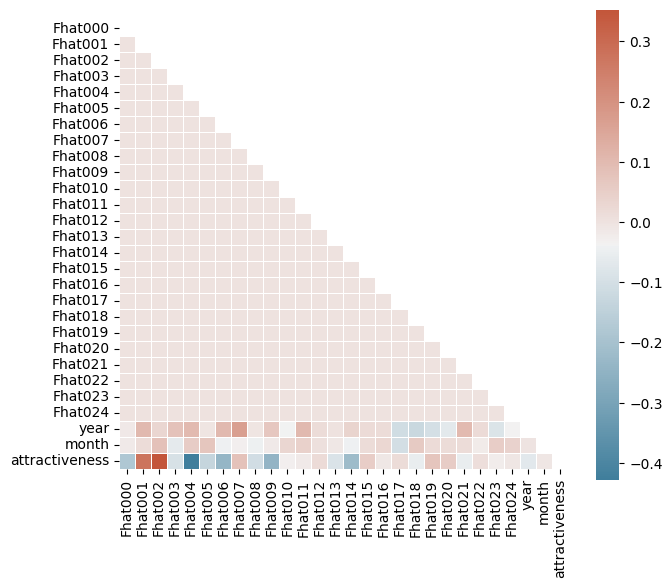

In [25]:
# heatmap of correlations
# Create plot
fig, axes = plt.subplots(figsize=(7, 6))
fig.set_tight_layout(True)

# Compute correlation matrix
corr = embeddings_ym.drop(columns = 'img_id').corr()

# Create upper triangular matrix to mask the upper triangular part of the heatmap
corr_mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap (because it looks better)
corr_cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask = corr_mask, cmap=corr_cmap, annot=False,square = True, linewidths=.5, ax = axes)
plt.show()

In [ ]:
# In the case of attractiveness we can see that the correlation is in some way correlated with some features. The case for year and month is almost close to zero.

#### **3. Training multiple models: Regression model, Random forest and Multilayer perceptron (MLP) for predicting attractiveness**<br>
Often, a researcher does not know beforehand which sort of model will do well, and which will not. Therefore, ML researchers often apply multiple models to their task and pull together their outcomes.<br>

Next, we are going to apply 3 models:
1. Regression model (benchmark model)<br>
2. Random Forest (RF)<br>
3. Multilayer Perceptron (MLP)<br>

As we will see, each of these models provide complementary insights. (maybe delete)

##### 3.1. Preparing the dataset

In [26]:
# Merging the embeddings with the original dataset
image_embeddings = pd.merge(img_metadata, embeddings, on='img_id')
image_embeddings.head(5)

img_id              img_path  year  month        lat       lng  \
0       0  image_261669_s_a.png  2019      5  51.992875  4.595223   
1       1  image_261609_s_a.png  2021      1  51.992723  4.595357   
2       2  image_261683_s_a.png  2017      7  51.993201  4.594991   
3       3  image_261590_s_a.png  2016      7  51.991961  4.595907   
4       4  image_261599_s_a.png  2017      7  51.992304  4.595650   

            hex_id  attractiveness  in_folder  \
0  8b19694da002fff        0.745663          0   
1  8b19694da003fff        0.729360          0   
2  8b19694da006fff        0.767513          0   
3  8b19694da008fff        0.721686          0   
4  8b19694da00efff        0.572475          0   

                                      geometry  ...   Fhat015   Fhat016  \
0  POINT (4.595222685014539 51.99287530050394)  ...  0.093596 -0.024934   
1  POINT (4.595357078817679 51.99272273221405)  ...  0.278526  0.025043   
2  POINT (4.594991324900168 51.99320148208828)  ... -0.053597 -0.061117   
3  POINT (4.595907157483683 51.99196149007253)  ...  0.083257 -0.193682   
4   POINT (4.595650423709793 51.9923038769158)  ...  0.126639 -0.009587   

    Fhat017   Fhat018   Fhat019   Fhat020   Fhat021   Fhat022   Fhat023  \
0 -0.183208 -0.329915  0.334317 -0.034518 -0.005868 -0.170634 -0.033538   
1 -0.273027 -0.256410  0.200388 -0.166567  0.180788 -0.246929  0.179483   
2  0.003480 -0.470245 -0.163239  0.103589 -0.206567 -0.512829 -0.079979   
3 -0.133317 -0.243234  0.292501 -0.263785 -0.194097 -0.337674 -0.119035   
4  0.236805 -0.441034 -0.283703 -0.013882  0.274577 -0.402516 -0.147622   

    Fhat024  
0 -0.085577  
1  0.129283  
2 -0.046585  
3  0.036482  
4  0.223398  

[5 rows x 35 columns]

In [27]:
# Generating the embedding columns
df = image_embeddings.copy()
emb_cols = embeddings.drop(columns=['img_id']).columns
features = emb_cols.to_list()
predict = 'attractiveness'

# Setting all dataset between 0 and 1
scaler = StandardScaler()
df[features + [predict]] = scaler.fit_transform(df[features + [predict]])

# Splitting the dataset
X_train, X_test, Y_train, Y_test = train_test_split(df[features], df[predict], test_size=0.2, random_state=44)

In [28]:
df[features + [predict]]

Fhat000   Fhat001   Fhat002   Fhat003   Fhat004   Fhat005   Fhat006  \
0      -1.079593  0.360220  0.232305  0.609018 -1.215010  0.133095 -0.331898   
1      -0.932930  0.987813  1.099532  0.351806 -1.184395  0.024840 -0.334561   
2      -0.150226  0.652673  2.005531 -0.074093 -1.506158 -0.212789 -1.522354   
3       0.240899  1.250386  0.040095  0.338446 -1.716355  0.233268 -0.522380   
4       0.963401  0.717600  1.524741 -0.249907 -1.803881 -0.594220 -1.174265   
...          ...       ...       ...       ...       ...       ...       ...   
101439  0.232833 -1.062858 -0.986286  0.244201 -1.044479  1.217738 -1.179047   
101440 -0.171973  0.853529  1.285120  0.940481 -1.007471 -0.229363 -0.743793   
101441 -1.151046  1.512556  1.208904  0.007014 -0.272804  0.655069 -2.000057   
101442  0.316938  1.126433 -0.186125 -0.560805 -1.273944 -0.847941  0.079007   
101443 -0.179018 -0.051263  0.591888 -0.145974 -1.498981 -0.417973 -0.886687   

         Fhat007   Fhat008   Fhat009  ...   Fhat016   Fhat017   Fhat018  \
0       0.524535  1.743588 -0.319998  ... -0.092666 -0.684803 -1.266292   
1       0.315580  1.261681 -0.531087  ...  0.093071 -1.020532 -0.984161   
2       0.049451 -0.919762 -0.253108  ... -0.227137  0.013008 -1.804908   
3       0.650335 -0.245895 -0.520848  ... -0.719808 -0.498319 -0.933588   
4      -0.450666 -0.673172 -0.125471  ... -0.035629  0.885138 -1.692789   
...          ...       ...       ...  ...       ...       ...       ...   
101439 -1.263191 -0.462513 -0.387330  ...  0.181786  1.185967 -0.059207   
101440  0.183752 -0.372537 -0.344565  ... -0.544859  0.548588 -1.951672   
101441 -0.862608 -1.672096  0.061030  ...  0.214429  0.387937  1.711408   
101442  1.024963 -1.275111  0.138820  ... -1.429711 -0.589277 -1.067508   
101443  0.432669 -1.371712  0.556429  ... -0.445608  0.929002 -1.556972   

         Fhat019   Fhat020   Fhat021   Fhat022   Fhat023   Fhat024  \
0       1.330234 -0.145591 -0.025185 -0.754624 -0.155662 -0.400085   
1       0.797333 -0.702553  0.775919 -1.092037  0.833046  0.604414   
2      -0.649520  0.436921 -0.886556 -2.267970 -0.371213 -0.217788   
3       1.163847 -1.112603 -0.833039 -1.493350 -0.552486  0.170555   
4      -1.128843 -0.058553  1.178448 -1.780115 -0.685170  1.044413   
...          ...       ...       ...       ...       ...       ...   
101439  0.041130 -0.513666 -0.321111  0.029234  0.448321 -0.332964   
101440  0.394804  0.377694  0.352944 -1.120812 -0.408540 -1.034365   
101441 -0.860293  0.473920  0.646588  0.022638 -1.160990 -0.109995   
101442  1.035967 -1.810865 -1.857396 -1.297989  1.720906  0.724506   
101443  0.346767 -1.203409 -0.963202 -2.709178  2.175687  1.688507   

        attractiveness  
0             1.947365  
1             1.916592  
2             1.988611  
3             1.902106  
4             1.620453  
...                ...  
101439       -0.533353  
101440        1.675217  
101441        1.749067  
101442        2.290428  
101443        2.658504  

[101444 rows x 26 columns]

Because we are going to compare different models, we create a custom evaluation function that allows us to swiftly report the following stats for the train and test data:
* mean square error
* mean absolute error
* R2

In [29]:
def eval_regression_perf(model, X_train, X_test, Y_train, Y_test):

    # Make prediction with the trained model
    Y_pred_train = model.predict(X_train)
    Y_pred_test = model.predict(X_test)

    # Create a function that computes the MSE, MAE, and R2
    def perfs(Y,Y_pred):
        mse = mean_squared_error(Y,Y_pred)
        mae = mean_absolute_error(Y,Y_pred)
        R2 = r2_score(Y,Y_pred)
        return mse,mae,R2

    # Apply the perfs function to the train and test data sets
    mse_train, mae_train, r2_train = perfs(Y_train,Y_pred_train)
    mse_test,  mae_test , r2_test  = perfs(Y_test,Y_pred_test)

    # Print results
    print('Performance')
    print(f'Mean Squared  Error Train | Test: \t{mse_train:>7.4f}\t|  {mse_test:>7.4f}')
    print(f'Mean Absolute Error Train | Test: \t{mae_train:>7.4f}\t|  {mae_test:>7.4f}')
    print(f'R2                  Train | Test: \t{ r2_train:>7.4f}\t|  {r2_test:>7.4f}\n')

##### 3.2. Linear multiple regression model
This model usually serves as a benchmark when creating ML models. Therefore, we start with this model.

Performance
Mean Squared  Error Train | Test: 	 0.3485	|   0.3515
Mean Absolute Error Train | Test: 	 0.4624	|   0.4621
R2                  Train | Test: 	 0.6504	|   0.6528



<Axes: >

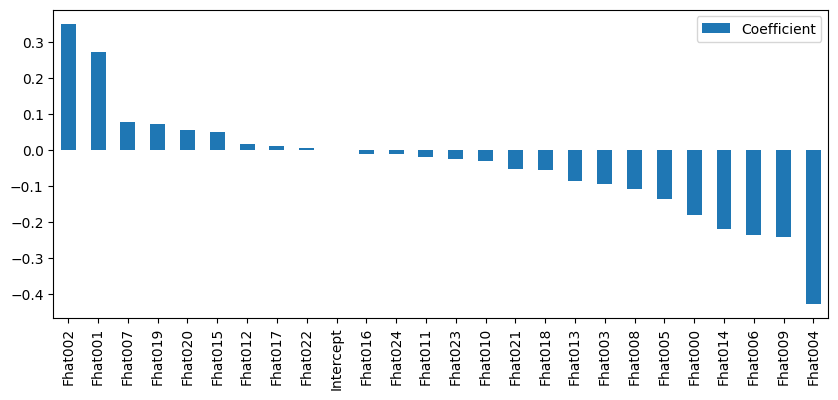

In [30]:
# Create and train a multiple linear regression model
regr = LinearRegression(fit_intercept = True)

# Fit the model on the training data
regr.fit(X_train,Y_train)

# Evaluate the performance of the trained model
eval_regression_perf(regr, X_train, X_test, Y_train, Y_test)

# We take an ML approach (i.e. we use a train and tests set). But, we can still look at the regression coefficients to see which features are more important than others.
regr_results_int = pd.DataFrame(index = ['Intercept'], data = regr.intercept_, columns = ['Coefficient'])
regr_results_wei = pd.DataFrame(index = df[features].columns, data = regr.coef_, columns = ['Coefficient'])
regr_results = pd.concat([regr_results_int,regr_results_wei],axis=0)

# Show the results
regr_results.sort_values(by='Coefficient', ascending=False).plot(kind='bar', figsize=(10, 4))

Based on these results, we can make several inferences:
1. The model fit relatively well (R2 of ~0.65)
2. The model does not seem to overfit the data: it attains the same performance on the test as on the train data sets
3. Based on the plot, we can infer that most feature are likely to contribute to the prediction performance, since they are nonzero.
4. Based on the plot, we can infer that, according to this model, Fhat004, Fhat002, and Fhat001 are the most important features.

##### 3.3. Random Forest (RF)
Now, we are going to try a RF on these data. RFs are known to attain a high model performance on a wide range of regression and classification tasks.
<br>
RFs need hyperparameter tuning. Instead of manually searching for the optimal hyperparameters for the RF, which is laborious, let's use sk-learn's GridSearchCV functionality to automate the hyperparameter search. In practice, typically, we want to search over the 4 most important hyperparameters: `max_depth`, `max_leaf_nodes`, `min_samples_leaf`, `max_features`. However, to avoid too long compuatational times during this lab session, here we restrict the tuning to the first two hyperparameters and try only two levels.  

In [31]:
# Create RF object for hyperparameter tuning
rf_gs = RandomForestRegressor(n_estimators=50,criterion= "squared_error",random_state=5)

# Define the hyperparameter search space
hyperparameter_space = {
    'max_depth': [5, 20],
    'max_leaf_nodes': [500,2500],
    # 'min_samples_leaf': [15],     # Not tuned here too avoid long computation time
    # 'max_features':[0.7]          # Not tuned here too avoid long computation time
    }

# Create scoring function
scorer = make_scorer(mean_squared_error, greater_is_better = False)

# Create the grid_search object, with using the MLP classifier
folds = 5 # Number of cross validation splits
rf_gridsearch = GridSearchCV(rf_gs, hyperparameter_space, n_jobs=-1, cv=folds, scoring=scorer, return_train_score=True)

In [34]:
rf_gs.fit(X_train, Y_train)
eval_regression_perf(rf_gs, X_train,X_test, Y_train, Y_test)

Performance
Mean Squared  Error Train | Test: 	 0.0526	|   0.3657
Mean Absolute Error Train | Test: 	 0.1767	|   0.4724
R2                  Train | Test: 	 0.9472	|   0.6388



In [32]:
# if the model RF_gridsearch.pickle does not exist, conduct the gridsearch, else load the grid_search object
if not Path('data/RF_gridsearch.pickle').exists():

    # Fit the grid search object to the training data
    # Note that this is computationally expensive!
    # It may take up to 5 minutes, since multiple models need to be trained multiple times
    rf_gridsearch.fit(X_train, Y_train)

    # Save the trained grid_search object
    with open('data/RF_gridsearch.pickle', 'wb') as f:
        pickle.dump(rf_gridsearch, f)
else:
    # Load the trained grid_search object
    with open('data/RF_gridsearch.pickle', 'rb') as f:
        rf_gridsearch = pickle.load(f)

# Print the best parameters
print('Best parameters:')
print(f'Tuned hyperparameters:\n{rf_gridsearch.best_params_}')
print(f'Mean Squared Error:\t{(-rf_gridsearch.best_score_):0.3f}')

KeyboardInterrupt: ignored

In [ ]:
# Create a dataframe from the results
df_results = pd.DataFrame(rf_gridsearch.cv_results_)

# Extract relevant columns
df_results = df_results[['params', 'mean_test_score', 'mean_train_score']]

# Display the top performing models in a plot
top_models = df_results.sort_values(by='mean_test_score', ascending=False)

# Create a figure
fig, ax = plt.subplots(figsize=(10, 3))

# Convert the dict row names to a list of strings, and replace the commas with newlines
param_list = [str(dict_) for dict_ in top_models['params']]
param_list = [param.replace(',', '\n') for param in param_list]
param_list = [param.replace('{', '')   for param in param_list]
param_list = [param.replace('}', '')   for param in param_list]

# Create a barplot
sns.barplot(x= param_list, y=top_models['mean_test_score'], ax=ax)

# Set the x-axis labels to the parameter list
ax.set_xticklabels(param_list, rotation=90)

# Show the plot
plt.show()

In [36]:
# Set the hyperparameters of the Random Forest to the best values found, e.g.
#max_depth = rf_gridsearch.best_params_['max_depth']
#max_leaf_nodes = rf_gridsearch.best_params_['max_leaf_nodes']
max_depth = 20
max_leaf_nodes=500
max_features = 0.7
min_samples_leaf = 15

# Create the Random Forest object with the best hyperparameters
rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth, max_features=max_features, max_leaf_nodes=max_leaf_nodes, min_samples_leaf=min_samples_leaf, random_state=0,n_jobs=-1)

# Train the Randon Forest
rf.fit(X_train,Y_train)

# Evaluate the performance of the hyperparameter optimised RF model
eval_regression_perf(rf,X_train,X_test, Y_train, Y_test)

Performance
Mean Squared  Error Train | Test: 	 0.3537	|   0.4106
Mean Absolute Error Train | Test: 	 0.4666	|   0.5030
R2                  Train | Test: 	 0.6452	|   0.5945



Let's see which features are found to be most important to our Random Forest.

In [ ]:
# Plot the feature importances
fig, ax = plt.subplots(figsize=(8,10))
sns.barplot(y=features,x=rf.feature_importances_, ax = ax).set(title='Feature importance to predict Attractiveness')
ax.set_xlabel('Feature importance')

# Print most important features
sorted_indices = np.argsort(rf.feature_importances_)[::-1]
most_imp_features_rf = [features[i] for i in sorted_indices]
print(f'Top 5 most important features:\n {most_imp_features_rf[:6]}')

# Show plot
plt.show()

However, as explained before, the embeddings are not semantically interpretable.

Nonetheless, we can draw some inference from it:
1. In line wit the linear multiple regression, we see that Fhat004 is the most important feature for the prediction. In contrast with the linear regression, Fhat001 is less important to the RF.
1. A few features are strong predictors, while most others contribute only modestly to the prediction.

#### 3.4 Multilayer perceptions (MLP)

### <span style="color:skyblue">Exercise 4: Apply GridSearch now using MLP to predict the attractiveness</span>
More specifically, tune the size of the hidden layers, the regularisation, and the learning rate. Use for each of these hyperparameters, no more than two levels to avoid too long compuational times.

In [37]:
# Create MLP object (plain vanilla MLP)
mlp_gs = MLPRegressor(activation = 'tanh', solver='adam', batch_size=250, max_iter=2000)

# Define the hyperparameter search space
# 'hidden_layer_sizes' defines the number of nodes and layers
# 'alpha' governs the L2 regularisation
# 'learning_rate_init' governs the learning rate.
hyperparameter_space = {

    'hidden_layer_sizes': [(20,20),(30,30),(25,25)],
    'alpha': [1,0.1,0.01],
    #'alpha': [1,0.1,0.01],
    #'learning_rate_init': [0.01, 0.001,0.0001, 0.00001]}
    'learning_rate_init': [0.01, 0.001]}

# Create scoring function
scorer = make_scorer(mean_squared_error, greater_is_better = False)

# Create the grid_search object, with using the MLP classifier
folds = 5 # Number of cross validation splits
mlp_gridsearch = GridSearchCV(mlp_gs, hyperparameter_space, n_jobs=-1, cv=folds,scoring = scorer)

In [39]:
# Create and train a MLP model (sklearn)
hidden_layer_sizes = (30,30)
alpha = 1
learning_rate_init =0.01

mlp_gs = MLPRegressor(hidden_layer_sizes = hidden_layer_sizes, alpha = alpha, learning_rate_init = learning_rate_init, activation='tanh', solver='adam', batch_size = 250 , max_iter=2000, random_state=1)
mlp_gs.fit(X_train,Y_train.to_numpy().ravel())

# Evaluate the performance of the trained model
eval_regression_perf(mlp_gs, X_train, X_test, Y_train.to_numpy().ravel(), Y_test.to_numpy().ravel())

Performance
Mean Squared  Error Train | Test: 	 0.3215	|   0.3260
Mean Absolute Error Train | Test: 	 0.4454	|   0.4467
R2                  Train | Test: 	 0.6775	|   0.6780



In [38]:
# if the model mlp_gridsearch.pickle does not exist, conduct the gridsearch, else load the grid_search object
if not Path('mlp_gridsearch.pickle').exists():

    # Fit the grid search object to the training data
    # Note that this is computationally expensive!
    # It may take up to 5 minutes, since multiple models need to be trained multiple times
    mlp_gridsearch.fit(X_train, Y_train)

    # Save the trained grid_search object
    with open('mlp_gridsearch.pickle', 'wb') as f:
        pickle.dump(mlp_gridsearch, f)
else:
    # Load the trained grid_search object
    with open('mlp_gridsearch.pickle', 'rb') as f:
        mlp_gridsearch = pickle.load(f)

KeyboardInterrupt: ignored

In [ ]:
print(f'Optimal hyperparameters:\n{mlp_gridsearch.best_params_}')
print(f'Mean Squared Error:\t{(-mlp_gridsearch.best_score_):0.3f}')

In [ ]:
# Create and train a MLP model (sklearn)
hidden_layer_sizes = mlp_gridsearch.best_params_['hidden_layer_sizes']
alpha = mlp_gridsearch.best_params_['alpha']
learning_rate_init = mlp_gridsearch.best_params_['learning_rate_init']

mlp_gs = MLPRegressor(hidden_layer_sizes = hidden_layer_sizes, alpha = alpha, learning_rate_init = learning_rate_init, activation='tanh', solver='adam', batch_size = 250 , max_iter=2000, random_state=1)
mlp_gs.fit(X_train,Y_train.to_numpy().ravel())

# Evaluate the performance of the trained model
eval_regression_perf(mlp_gs, X_train, X_test, Y_train.to_numpy().ravel(), Y_test.to_numpy().ravel())

#### **3.5 Comparing and reflecting on the model performances and their outcomes**

Often it helps the researcher to pull together the outcomes of multiple models. The idea of doing this is closely related to wisdom of the crowd principle. If multiple different model point towards the same conclusion, then the researcher has compounding evidence. In contrast, if different models point towards different conclusions, then the researcher knows the conclusions are weak(er) and sensitive to the choice of model.<br>
Let's pull together the predictions of the 3 ML models, and show them next to one another.

In [ ]:
# Scatter true shares (x-axis) against the predicted shares by the different ML models (y-axis)
fig, ax = plt.subplots(1,3,figsize=(18,4), sharex=True, sharey=True)
ax[0].scatter(x = Y_test, y = regr.predict(X_test),  marker = '.', s = 25, alpha = 0.2, c = '#ff7f0e', label = f'Regression | R2 = {regr.score(X_test,Y_test):0.3f}')
ax[1].scatter(x = Y_test, y = rf.predict(X_test),    marker = '.', s = 25, alpha = 0.2, c = '#2ca02c', label = f'Random Forest| R2 = {rf.score(X_test,Y_test):0.3f}')
ax[2].scatter(x = Y_test, y = mlp_gs.predict(X_test),marker = '.', s = 25, alpha = 0.2, c = '#d62728', label = f'MLP | R2 = {mlp_gs.score(X_test,Y_test):0.3f}')

# Add labels, legend, and title to each plot
for n in range(0,3,1):
    ax[n].set_xlabel('True Attractiveness')
    ax[n].set_ylabel('Predicted attractiveness')
    ax[n].set_xlim(-4,4)
    ax[n].set_ylim(-4,4)
    ax[n].legend()
    ax[n].set_title('True versus predicted attractiveness (test data)')

plt.show()

### <span style="color:skyblue">Exercise 5:  Comparison of predictions</span>
`A` What is the most striking difference between the predictions across the three ML models? Can you explain this?<br>
`B` How would the (ideal) scatter plot look like? I.e. when the model would perfectly predict our target?


In [ ]:
# CODE YOUR ANSWERS HERE (Use as many cells as you need)


Another way the compare the predictions of the three models is by creating a **kernel density plot**. A kernel density plot visualises the distribution, i.e. the probability density, of a variable, in a smooth way, see e.g. [wikipedia.org/wiki/Kernel_density_estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation).

In [ ]:
# Plot kernel densities for the test data
fig, ax = plt.subplots(figsize=(10, 7))

# Plot kernel density of the true distribution, i.e of Y_test
sns.kdeplot(data = Y_test, ax=ax, legend=True,fill=True,alpha=.3, clip =(-4,4), label = 'True')

# Plot kernel densities of the predicted distributions, based on the three models
sns.kdeplot(data = regr.predict(X_test),ax=ax, legend=True,fill=True,alpha=.3, clip =(-4,4), label = f'Regression | R2 = {regr.score(X_test,Y_test):0.3f}')
sns.kdeplot(data = rf.predict(X_test),  ax=ax, legend=True,fill=True,alpha=.3, clip =(-4,4), label = f'Random Forest | R2 = {rf.score(X_test,Y_test):0.3f}')
sns.kdeplot(data = mlp_gs.predict(X_test),  ax=ax, legend=True,fill=True,alpha=.3, clip =(-4,4), label = f'MLP | R2 = {mlp_gs.score(X_test,Y_test):0.3f}')

# Add legend and title to the plot
#ax.legend(['True','Regression model', 'Decision tree','Random Forest'])
ax.legend()
plt.title('True vs predicted Attractiveness')
ax.set_xlim(-4,4)
plt.show()

### <span style="color:skyblue">Exercise 6:   Conclusion and reflection on the results</span>
In this lab session we have analysed urban visual data, and made predictions for attractiveness using three ML models.<br>
`A` Based on the above analyses, which of these models can best be used to predict visual attractiveness of the urban space? Explain your answer.<br>
`B` In the kernel density plots, we see that the true variance of attractiveness (in blue) is considerably larger than the variance of attractiveness predicted by any of the ML models. What does this tell us about this regression problem?<br>
`C` How has applying multiple ML models helped you achieving your research goal?<br>

In [ ]:
# CODE YOUR ANSWERS HERE (Use as many cells as you need)